# Centric Pricing Technical Challenge

### Rubén Barco Terrones
#### October, 2023

### Libraries and Functions

In [51]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import random
import imutils

from tqdm import tqdm
from matplotlib import pyplot
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet201

In [2]:
def plot_random_samples_per_class(images_array: np.ndarray, 
                                  labels: np.ndarray, 
                                  n_images_per_class: int = 3, 
                                  figure_size: tuple = (6, 18)) -> None:
    
    '''
    Function that plots random selected samples from each class of the data.
    :param images_array: array with the loaded data
    :param labels: labels of the images in images_array
    :param n_images_per_class: number of images per that that are going to be plotted
    :param figure_size: tuple with the size of the output image
    '''
    
    assert labels.shape[0] == images_array.shape[0], 'There must be the same number of labels than images in the array'
    
    # We obtain the number of different classes and use some loops to fill the subplots.
    m = len(set(list(labels)))

    fig = pyplot.figure(figsize = figure_size)
    count = 1
    for i in range(m):
        x_i = images_array[labels == i]
        random_choices = np.random.choice(range(0, x_i.shape[0]), n_images_per_class, replace = False)

        for j in range(n_images_per_class):
            ax = fig.add_subplot(m, n_images_per_class, count)
            pyplot.imshow(x_i[random_choices[j]], cmap='Greys_r')
            pyplot.title(i)
            pyplot.axis('off')
            count += 1

In [3]:
def plot_class_distribution(labels: np.ndarray, 
                            figure_size: tuple = (6,3), 
                            title: str = 'Distribution of Classes', 
                            plot_type:str = 'bar') -> None:
    '''
    Function that plots the classes distribution in a bar or pie chart.
    :param labels: array with labels
    :param figure_size: tuple with the size of the output image
    :param title: title of the plot
    :param plot_type: type of plot to show the distribution (bar or pie)
    '''
    
    assert len(labels) > 0, "Empty list of labels."
    assert plot_type in ['pie', 'bar'], "Chart types supported: 'pie' and 'bar'."
    
    fig = pyplot.figure(figsize = figure_size)
    if plot_type == 'pie':
        pyplot.pie(Counter(labels).values(), explode=(0, 0, 0, 0, 0), 
                   labels=Counter(labels).keys(), autopct='%1.1f%%')
    elif plot_type == 'bar':
        pyplot.bar(Counter(labels).keys(), Counter(labels).values(), width = .5)
        pyplot.xlabel('Class Name')
        pyplot.ylabel('# Images')
    
    pyplot.title(title)

In [4]:
def resize_images(input_array:np.ndarray, desired_w:int = 32, desired_h:int = 32) -> np.ndarray:
    '''
    Function that resized the images of the input array to a specific width and height.
    :param input_array: array with the images. Images must have 2D
    :param desired_w: desired width of the output images
    :param desired_h: desired height of the output images
    :output input_array_reshaped: array with the same number of images as the input one but with the images resized
    '''
    
    assert len(input_array.shape)==3, "Input array must have 3 dimensions."
    assert desired_w > 0, "Desired width must be alt least 1."
    assert desired_h > 0, "Desired height must be alt least 1."
    
    input_array_reshaped = np.zeros((input_array.shape[0], desired_h, desired_w))
    for i in range(input_array.shape[0]):
        input_array_reshaped[i] = cv2.resize(input_array[i], (desired_w, desired_h)) # by default bilinear interpolation
    return input_array_reshaped

In [5]:
def reshape_images(input_array:np.ndarray) -> np.ndarray:
    '''
    Function that reshape the images from 1 unique layer to 3 layers mantaining the gray colormap.
    :param input_array: array with the images. Images must have 2 dimensions (h x w)
    :output input_array_reshaped: array with the same number of images as the input one but with the images reshaped
    '''
    
    assert len(input_array.shape)==3, "Input array must have 3 dimensions."
    
    input_array_reshaped = np.zeros((input_array.shape[0], input_array.shape[1], input_array.shape[2], 3))
    for i in range(input_array.shape[0]):
        input_array_reshaped[i] = cv2.cvtColor(input_array[i], cv2.COLOR_GRAY2BGR) # Applies a transformation from 1layer to 3layers 
    return input_array_reshaped

In [6]:
def horizontal_flip_image(input_image:np.ndarray) -> np.ndarray:
    '''
    This function perform a horizontal flip on the input image.
    :param input_image: image to perform the horizontal flip on
    :output output_image: flipped image
    '''
    output_image = cv2.flip(input_image, 1)
    return output_image

def rotate_image(input_image:np.ndarray, rotation_angle:int = 45) -> np.ndarray:
    '''
    This function perform a rotation on the input image.
    :param input_image: image to perform the rotation on
    :param rotation_angle: it specifies the degrees of rotation
    :output output_image: rotated image
    '''
    output_image = imutils.rotate(input_image, angle = rotation_angle)
    return output_image

def add_noise_to_image(input_image:np.ndarray, mean:np.float32 = 0., var:np.float32 = 0.005) -> np.ndarray:
    '''
    This function add noise to the input image.
    :param input_image: image to add the noise on
    :param mean: mean of the normal distribution of the noise to add to the original image
    :param var: variance of the normal distribution of the noise to add to the original image
    :output output_image: noisy image
    '''
    
    h, w, _= input_image.shape
    m = mean
    v = var
    
    # We generate a random mask with the same dimensions than the input image with random noisy points
    # and add it to the image
    noise_mask = np.float32(np.random.normal(m, v**0.5, (h, w)))
    noise_mask = cv2.cvtColor(noise_mask, cv2.COLOR_GRAY2BGR) # 1 layer to 3 layers
    output_image = input_image + noise_mask
    
    # We limit the greatest value to 1 and the lowest to 0
    output_image[output_image>1] = 1.
    output_image[output_image<0] = 0.
    
    return output_image

In [7]:
def data_augmentation(input_data:np.ndarray, 
                      input_labels:list, 
                      method:str = 'horizontal_flip', 
                      class_name:str = 'Footwear', 
                      number_of_new_samples:int = 100) -> (np.ndarray, list):
    
    '''
    This function perform a data augmentation to the input data. It provides three possible options: 
    horizontal flip, rotation or adding noise.
    :param input_data: input set of images to use for data augmentation
    :param input_labels: input labels with the same length as the number of images
    :param method: data augmentation method to perform to a total of number_of_new_samples random images picked from input data
    :param class_name: class to apply the data augmentation to
    :param number_of_new_samples: number of new images that we are going to generate
    :output data_augmented: array with the new images generated
    :output labels_augmented: list of labels for these new images
    '''
    
    assert len(input_data.shape)==4, "Input data must have shape (x, y, z, 3)."
    assert input_data.shape[0] == len(input_labels), "There must be the same number of labels than images in the array."
    assert method in ['horizontal_flip', 'rotation', 'add_noise'], "Data augmentation methods suported: 'horizontal_flip', 'rotation' or 0add_noise'."
    assert class_name in ['Footwear', 'Upper part', 'One piece', 'Bottom part', 'Bags'], "Existing classes names: 'Footwear', 'Upper part', 'One piece', 'Bottom part', 'Bags'."
    assert number_of_new_samples > 0, "Number of new samples must be at least 1."
    
    # First we create an array of zeros with the number of new images and the size of an image and
    # filter the images in which the labels are equal to class_name
    data_augmented = np.zeros((number_of_new_samples, input_data.shape[1], input_data.shape[2], input_data.shape[3]))
    input_data_class = input_data[[label==class_name for label in input_labels]]
    
    if method == 'horizontal_flip':
        # Randomly pick an image and apply the horizontal flip
        for i in tqdm(range(number_of_new_samples)):
            sample = input_data_class[np.random.randint(0, input_data_class.shape[0])]
            data_augmented[i] = horizontal_flip_image(sample)
    elif method == 'rotation':
        # In this case we generate randomly a rotation dregree between -90 and 90
        for i in tqdm(range(number_of_new_samples)):
            angle = np.random.randint(-90, 91)
            sample = input_data_class[np.random.randint(0, input_data_class.shape[0])]
            data_augmented[i] = rotate_image(sample, angle)
    elif method == 'add_noise':
        # Here we add some gaussian noise to the image
        for i in tqdm(range(number_of_new_samples)):
            sample = input_data_class[np.random.randint(0, input_data_class.shape[0])]
            data_augmented[i] = add_noise_to_image(sample)
            
    labels_augmented = [class_name] * data_augmented.shape[0]
    
    return data_augmented, labels_augmented

In [65]:
def plot_confusion_matrix(confusion_matrix: pd.DataFrame, 
                          title:str = 'Confusion Matrix',
                          figure_size:tuple = (5, 4)) -> None:
    '''
    Function that plots the confusion Matrix.
    :param confusion_matrix: DataFrame with the confusion matrix values
    :param title: title of the plot
    :param figure_size: size of the plot
    '''
    pyplot.figure(figsize = figure_size)
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
    pyplot.title(title)
    pyplot.ylabel('Actual Values')
    pyplot.xlabel('Predicted Values')
    pyplot.show()

In [8]:
# Some dictionaries with the mapping between the old and new classes
str_mapping = {'Upper part': ['T-shirt/top', 'Pullover', 'Coat', 'Shirt'],
               'Bottom part': ['Trouser'],
               'One piece': ['Dress'],
               'Footwear': ['Sandal', 'Sneaker', 'Ankle boot'],
               'Bags': ['Bag']}

numeric_mapping = {'Upper part': [0, 2, 4, 6],
                   'Bottom part': [1],
                   'One piece': [3],
                   'Footwear': [5, 7, 9],
                   'Bags': [8]}

### Loading and Analyzing Data

After reviewing the documentation of the Fashion MNIST dataset, as I am going to use Tensorflow and Keras in the models, I have decided that the best option to load the data is using also Tensorflow. The data contains images from 10 different classes with a total of `60.000` images for training and `10.000` images for testing.

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [10]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [11]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [12]:
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

In [13]:
Counter(y_test)

Counter({9: 1000,
         2: 1000,
         1: 1000,
         6: 1000,
         4: 1000,
         5: 1000,
         7: 1000,
         3: 1000,
         8: 1000,
         0: 1000})

We can see that the images are equaly distributed over the classes, but that is not important now because we are going to map these 10 classes to have 5 new ones. Let's plot some examples of the images to see what are we dealing with:

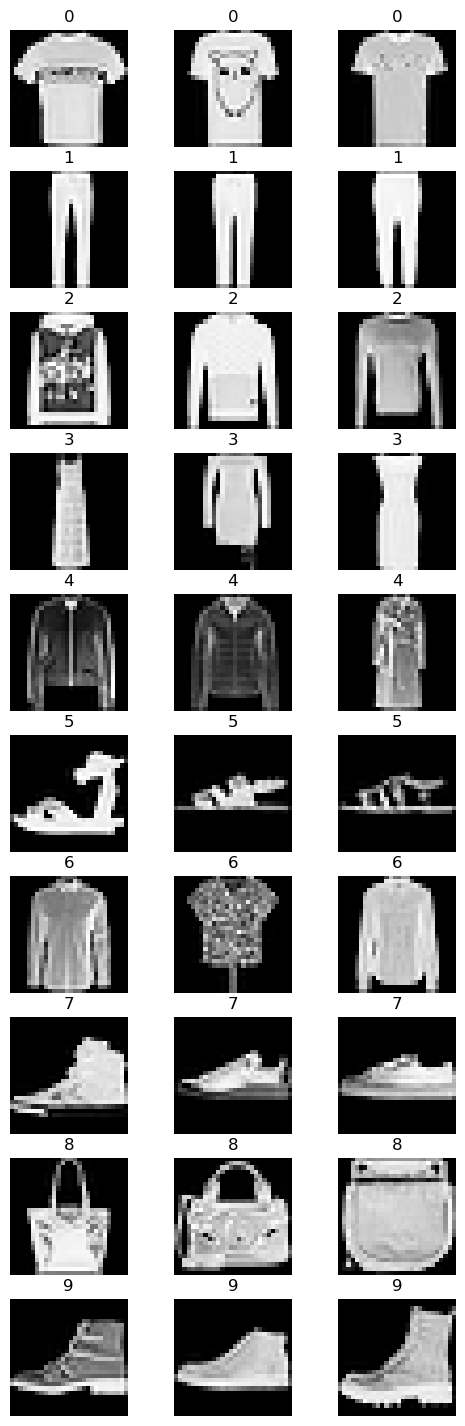

In [14]:
plot_random_samples_per_class(images_array = x_train, labels = y_train)

As it is requested, we need to map the classes to these new ones:
1. **Upper part**: T-shirt/top + Pullover + Coat + Shirt
2. **Bottom part**: Trouser
3. **One piece**: Dress
4. **Footwear**: Sandal + Sneaker + Ankle boot
5. **Bags**: Bag

In [15]:
def mapping_labels(n): 
    if (n==0) | (n==2) | (n==4) | (n==6):
        return 'Upper part'
    elif n==1:
        return 'Bottom part'
    elif n==3:
        return 'One piece'
    elif (n==5) | (n==7) | (n==9):
        return 'Footwear'
    elif n==8:
        return 'Bags'

In [16]:
# To check that we can change the values in the array, the parameter WRITEABLE has to be True
y_train.flags, y_test.flags

(  C_CONTIGUOUS : True
   F_CONTIGUOUS : True
   OWNDATA : False
   WRITEABLE : False
   ALIGNED : True
   WRITEBACKIFCOPY : False,
   C_CONTIGUOUS : True
   F_CONTIGUOUS : True
   OWNDATA : False
   WRITEABLE : False
   ALIGNED : True
   WRITEBACKIFCOPY : False)

In [17]:
# Making a copy of the data we achieve that
y_train = y_train.copy()
y_test  = y_test.copy()

# Then we use map to obtain the new labels
y_train = [*map(mapping_labels, y_train)]
y_test  = [*map(mapping_labels, y_test)]

In [18]:
# Let's see now how are the new classes distributed in training and test sets
Counter(y_train)

Counter({'Footwear': 18000,
         'Upper part': 24000,
         'One piece': 6000,
         'Bottom part': 6000,
         'Bags': 6000})

In [19]:
Counter(y_test)

Counter({'Footwear': 3000,
         'Upper part': 4000,
         'Bottom part': 1000,
         'One piece': 1000,
         'Bags': 1000})

As we can see, we are dealing now with an unbalance dataset. There are to classes with only 6.000 samples compared to the other two that have 18.000 and 24.000 samples. We can see this better with the following charts:

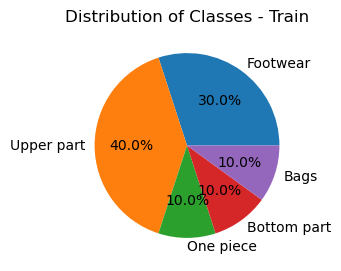

In [20]:
plot_class_distribution(labels = y_train, title = 'Distribution of Classes - Train', plot_type='pie')

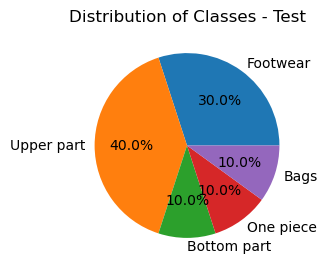

In [21]:
plot_class_distribution(labels = y_test, title = 'Distribution of Classes - Test', plot_type='pie')

We could also show the some charts with the size distribution of the images, but in this problem this is not needed because all have the same size `(28, 28)`. 

One important point to check is the possibility of having outliers in the data, for example, completely black or white images. One easy way of checking it is to compute the mean of the values per image and show the one with the greatest and the lowest mean values.

In [22]:
x_train_means = x_train.mean(axis=(1,2))

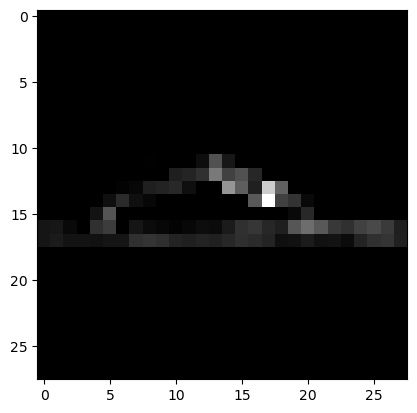

In [23]:
pyplot.imshow(x_train[x_train_means==x_train_means.min()][0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

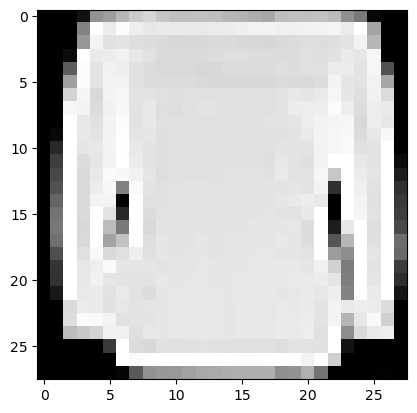

In [24]:
pyplot.imshow(x_train[x_train_means==x_train_means.max()][0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [25]:
x_test_means = x_test.mean(axis=(1,2))

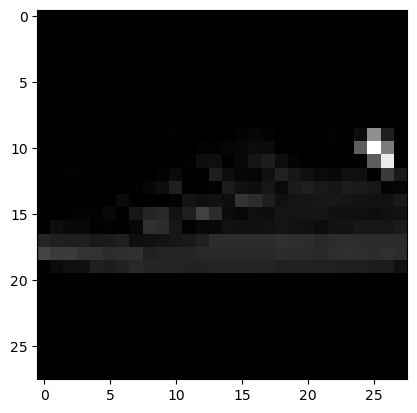

In [26]:
pyplot.imshow(x_test[x_test_means==x_test_means.min()][0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

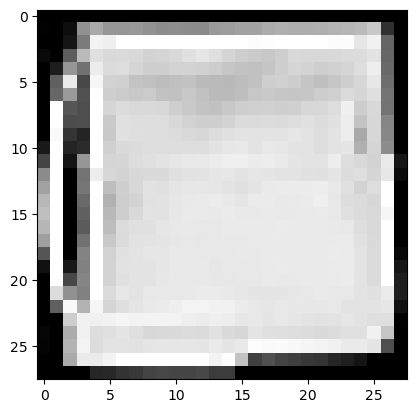

In [27]:
pyplot.imshow(x_test[x_test_means==x_test_means.max()][0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

We can see that the images are not outliers (even though the last one has a strage shape). So, now, let's prepare the data to the trainig process.

### Processing Data

As I have decided to use the model called DenseNet, we need to resize and reshape the images because the lowest resolution for the input images admitted by this pretrained model is `(32, 32, 3)`. 
* First, we are going to resize the images to `(32, 32)` and then we can reshape it to have 3 layers. 
* Another important step here is to transform the values from *float64* to *float32* to be able to transform it from 2D and 3D, and we also divided the values by 255 to have them in a range of [0,1].
* Finally, we reshape the images to obtain a shape of `(32, 32, 3)`.

In [28]:
# Resize, casting and normalization
x_train_resized = resize_images(input_array=x_train)
x_train_resized = np.float32(x_train_resized)  # Need to cast from float64 to float32 to be able to transform it from 2D to 3D
x_train_resized = x_train_resized/255.
x_test_resized = resize_images(input_array=x_test)
x_test_resized = np.float32(x_test_resized)  # Need to cast from float64 to float32 to be able to transform it from 2D to 3D
x_test_resized = x_test_resized/255.

In [29]:
# Reshape
x_train_reshaped = reshape_images(x_train_resized)
x_test_reshaped = reshape_images(x_test_resized)

In [30]:
# Let's check the new shapes
x_train_reshaped.shape, x_test_reshaped.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

### Baseline Experiment

For the first experiment, we are going to use the pretrained DenseNet model. This is a Neural Network developed by researches at Facebook AI Research. It uses dense connections, which means that layers are connected in a feed forward way. Dense connections allow the network to reuse features learned in previous layers and can help prevent overfitting. It consists of several dense blocks, each of which contains several convolutional layers, and then a transition layers that reduces the spatial dimension of the output. It has been proved to be more parameter efficient that other state of the art models. 

#### Splitting Data into Train and Validation

The data that we are going to use is the one that we have loaded, resized and reshaped, splitting it into train (50.000 samples) and validation (10.000 samples).

In [31]:
(trainX_base, valX_base, trainY_base, valY_base) = train_test_split(x_train_reshaped, y_train, 
                                                                    test_size = 1/6, 
                                                                    random_state = 42, 
                                                                    shuffle = True, 
                                                                    stratify = y_train)
trainX_base.shape, valX_base.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [32]:
Counter(trainY_base), Counter(valY_base)

(Counter({'One piece': 5000,
          'Footwear': 15000,
          'Bags': 5000,
          'Bottom part': 5000,
          'Upper part': 20000}),
 Counter({'Upper part': 4000,
          'Footwear': 3000,
          'One piece': 1000,
          'Bottom part': 1000,
          'Bags': 1000}))

In [33]:
onehotencoder = OneHotEncoder()
trainY_base = onehotencoder.fit_transform(np.array(trainY_base).reshape(-1, 1)).toarray()

In [34]:
valY_base = onehotencoder.transform(np.array(valY_base).reshape(-1, 1)).toarray()
testY_base = onehotencoder.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [35]:
onehotencoder.categories_

[array(['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'],
       dtype='<U11')]

#### Fine Tune Pretrained Model

We have to specify the input shape of out images, the weights (pre-trained on ImageNet) and we do not include the top fully-connected layer at the top of the network, so we can add some new layers to adapt it to our classification problem.

In [36]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(32,32,3))

We add 3 new dense layers, using always powers of 2 in a descending way until the last layer in which we need to have a vector of size 5 and a softmax activation due to the classification aim of the model. We use Dropout and regularization to reduce the overfitting.

In [37]:
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu', kernel_regularizer = l2(l = 0.03)))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu', kernel_regularizer = l2(l = 0.03)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(5,activation = 'softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

In [38]:
# We are going to fine tune also the last 10 layers of the DenseNet model, the rest are frozen
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
H = model.fit(trainX_base, trainY_base, validation_data = (valX_base, valY_base), batch_size = 64, epochs = 10)

Epoch 1/10
782/782 [==============================] - 239s 306ms/step - loss: 14.6058 - accuracy: 0.9205 - val_loss: 2.9167 - val_accuracy: 0.9566
Epoch 2/10
782/782 [==============================] - 248s 317ms/step - loss: 1.3325 - accuracy: 0.9551 - val_loss: 0.5292 - val_accuracy: 0.9653
Epoch 3/10
782/782 [==============================] - 251s 321ms/step - loss: 0.3346 - accuracy: 0.9643 - val_loss: 0.2168 - val_accuracy: 0.9680
Epoch 4/10
782/782 [==============================] - 243s 311ms/step - loss: 0.1720 - accuracy: 0.9695 - val_loss: 0.1704 - val_accuracy: 0.9619
Epoch 5/10
782/782 [==============================] - 242s 310ms/step - loss: 0.1301 - accuracy: 0.9721 - val_loss: 0.1409 - val_accuracy: 0.9682
Epoch 6/10
782/782 [==============================] - 241s 308ms/step - loss: 0.1101 - accuracy: 0.9752 - val_loss: 0.1287 - val_accuracy: 0.9706
Epoch 7/10
782/782 [==============================] - 261s 334ms/step - loss: 0.0976 - accuracy: 0.9788 - val_loss: 0.1426 

In [43]:
pred_val_base = np.argmax(model.predict(valX_base), axis=-1)
pred_test_base = np.argmax(model.predict(x_test_reshaped), axis=-1)

In [50]:
cm_val_base = confusion_matrix(np.argmax(valY_base, axis=-1), pred_val_base)
cm_val_base = pd.DataFrame(cm_val_base,
                           index = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'], 
                           columns = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'])

In [66]:
cm_test_base = confusion_matrix(np.argmax(testY_base, axis=-1), pred_test_base)
cm_test_base = pd.DataFrame(cm_test_base,
                            index = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'], 
                            columns = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'])

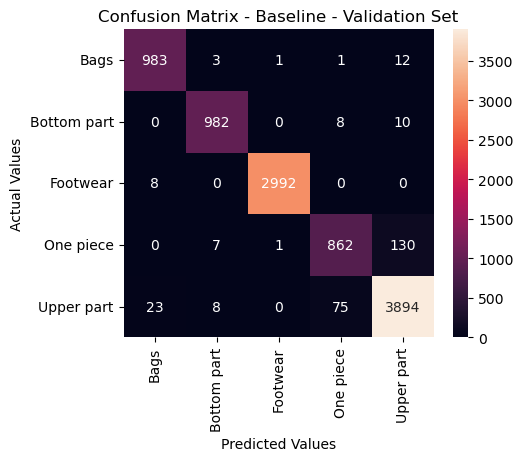

In [68]:
plot_confusion_matrix(confusion_matrix = cm_val_base, 
                      title = 'Confusion Matrix - Baseline - Validation Set')

As we can see on the Confusion Matrix. The results are pretty good in the validation set. There are two importan values here that confirms what we should have predicted. These values are 130 and 75, which corresponds to actual labels of One piece clothes predicted as Upper part clothes and viceversa. This makes sense. It is confirming that, as we have seen in previous image plottings, that these two classes are similar and can be difficult to differentiate for the model.

### Data Augmentation Experiment

In this case we are going to use the same model, freezing the same layers and fine tuning the rest. The difference here is that we are going to apply some data augmentation to the input data. As we have seen, we have the following number of samples for each class:
- **Bottom part**: 6.000
- **One piece**: 6.000
- **Bags**: 6.000
- **Footwear**: 18.000
- **Upper part**: 24.000

The idea is to use rotations, horizontal flip and adding noise to have 24.000 samples for each class. There is one point here. For the class with 24k samples, we are going to randomly select 18.000 of them to perform also the data augmentation until 24.000. That is because keeping the 24 samples could result in a model that is robust to noise, rotations and flip for 4 classes but not for the fifth one.

The final distribution of the samples is going to look like this:
- **Bottom part**: `6.000 original` + `6.0000 rotated` + `6.000 flipped` + `6.000 with noise`
- **One piece**: `6.000 original` + `6.0000 rotated` + `6.000 flipped` + `6.000 with noise`
- **Bags**: `6.000 original` + `6.0000 rotated` + `6.000 flipped` + `6.000 with noise`
- **Footwear**: `18.000 original` + `2.0000 rotated` + `2.000 flipped` + `2.000 with noise`
- **Upper part**: `18.000 original` + `2.0000 rotated` + `2.000 flipped` + `2.000 with noise`

#### Splitting Data into Train and Validation

The data that we are going to use is the one that we have loaded, resized and reshaped, splitting it into train (100.000 samples) and validation (2.000 samples).

In [67]:
new_samples_per_class = {'Bottom part': 6000,
                         'One piece': 6000,
                         'Bags': 6000,
                         'Footwear': 2000,
                         'Upper part': 2000,}

x_train_aug = x_train_reshaped[[label in ['Bottom part', 'One piece', 'Bags', 'Footwear'] for label in y_train]]
y_train_aug = [label for label in y_train if label in ['Bottom part', 'One piece', 'Bags', 'Footwear']]
x_upper_part = x_train_reshaped[[label=='Upper part' for label in y_train]]
list_i = [i for i in range(0, x_upper_part.shape[0])]
x_upper_part = x_upper_part[random.sample(list_i, 18000)]
y_upper_part = ['Upper part']*18000

x_train_aug = np.concatenate((x_train_aug, x_upper_part), axis=0)
y_train_aug = y_train_aug + y_upper_part
for class_name, n_new_samples in new_samples_per_class.items():
    for method in ['horizontal_flip', 'rotation', 'add_noise']:
        x_aug, y_aug = data_augmentation(input_data = x_train_reshaped, 
                                         input_labels = y_train, 
                                         method = method, 
                                         class_name = class_name, 
                                         number_of_new_samples = n_new_samples)
        
        x_train_aug = np.concatenate((x_train_aug, x_aug), axis=0)
        y_train_aug = y_train_aug + y_aug

100%|██████████| 2000/2000 [00:00<00:00, 6379.88it/s]


In [69]:
x_train_aug.shape, Counter(y_train_aug)

((120000, 32, 32, 3),
 Counter({'Footwear': 24000,
          'One piece': 24000,
          'Bottom part': 24000,
          'Bags': 24000,
          'Upper part': 24000}))

In [70]:
(trainX_aug, valX_aug, trainY_aug, valY_aug) = train_test_split(x_train_aug, y_train_aug, 
                                                                test_size = 1/6, 
                                                                random_state = 42, 
                                                                shuffle = True, 
                                                                stratify = y_train_aug)
trainX_aug.shape, valX_aug.shape

((100000, 32, 32, 3), (20000, 32, 32, 3))

In [71]:
Counter(trainY_aug), Counter(valY_aug)

(Counter({'Footwear': 20000,
          'Bottom part': 20000,
          'Upper part': 20000,
          'Bags': 20000,
          'One piece': 20000}),
 Counter({'Bags': 4000,
          'Bottom part': 4000,
          'One piece': 4000,
          'Footwear': 4000,
          'Upper part': 4000}))

In [72]:
onehotencoder = OneHotEncoder()
trainY_aug = onehotencoder.fit_transform(np.array(trainY_aug).reshape(-1, 1)).toarray()

In [73]:
valY_aug = onehotencoder.transform(np.array(valY_aug).reshape(-1, 1)).toarray()
testY_aug = onehotencoder.transform(np.array(y_test).reshape(-1, 1)).toarray()

In [74]:
onehotencoder.categories_

[array(['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'],
       dtype='<U11')]

In [75]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(32,32,3))

In [76]:
model_aug = Sequential()
model_aug.add(base_model)
model_aug.add(GlobalAveragePooling2D())
model_aug.add(Dense(1024, activation='relu', kernel_regularizer=l2(l=0.03)))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(128, activation='relu', kernel_regularizer=l2(l=0.03)))
model_aug.add(Dropout(0.1))
model_aug.add(BatchNormalization())
model_aug.add(Dense(5, activation='softmax'))

In [77]:
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)              

In [78]:
# We are going to fine tune also the last 10 layers of the DenseNet model, the rest are frozen
for layer in base_model.layers[:-10]:
    layer.trainable = False

model_aug.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

H_aug = model_aug.fit(trainX_aug, trainY_aug, validation_data=(valX_aug, valY_aug), batch_size = 64, epochs = 10)

Epoch 1/10
1563/1563 [==============================] - 519s 332ms/step - loss: 9.1621 - accuracy: 0.9039 - val_loss: 0.9826 - val_accuracy: 0.9471
Epoch 2/10
1563/1563 [==============================] - 519s 332ms/step - loss: 0.4732 - accuracy: 0.9438 - val_loss: 0.2389 - val_accuracy: 0.9549
Epoch 3/10
1563/1563 [==============================] - 515s 330ms/step - loss: 0.2001 - accuracy: 0.9559 - val_loss: 0.1601 - val_accuracy: 0.9627
Epoch 4/10
1563/1563 [==============================] - 501s 321ms/step - loss: 0.1581 - accuracy: 0.9611 - val_loss: 0.1417 - val_accuracy: 0.9666
Epoch 5/10
1563/1563 [==============================] - 512s 328ms/step - loss: 0.1390 - accuracy: 0.9657 - val_loss: 0.1380 - val_accuracy: 0.9643
Epoch 6/10
1563/1563 [==============================] - 489s 313ms/step - loss: 0.1245 - accuracy: 0.9693 - val_loss: 0.1251 - val_accuracy: 0.9692
Epoch 7/10
1563/1563 [==============================] - 486s 311ms/step - loss: 0.1141 - accuracy: 0.9723 - val_

In [79]:
pred_val_aug = np.argmax(model_aug.predict(valX_aug), axis=-1)
pred_test_aug = np.argmax(model_aug.predict(x_test_reshaped), axis=-1)

In [80]:
cm_val_aug = confusion_matrix(np.argmax(valY_aug, axis=-1), pred_val_aug)
cm_val_aug = pd.DataFrame(cm_val_aug,
                          index = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'], 
                          columns = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'])

In [81]:
cm_test_aug = confusion_matrix(np.argmax(testY_aug, axis=-1), pred_test_aug)
cm_test_aug = pd.DataFrame(cm_test_aug,
                           index = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'], 
                           columns = ['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part'])

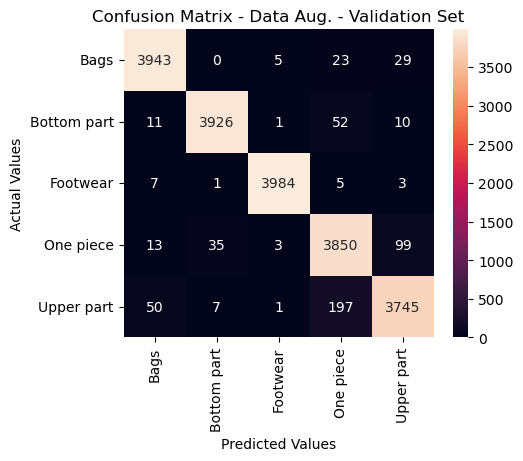

In [82]:
plot_confusion_matrix(confusion_matrix = cm_val_aug, 
                      title = 'Confusion Matrix - Data Aug. - Validation Set')

Again, we see the same effect as in the previous case: some One piece are classified as Upper part and viceversa, but if we compare the percentage of samples that they represent, it is lower than in the previous case.

### Model Comparison

Here we are going to compare both models in a simple way. The first one is using the training curves to represent the accuracy and the loss over the epochs. I know that in an unbalanced case as the one in the baseline model, the accuracy is not showing the exact reality, but it is a simple and fast way of the the model performance. 

On the othe hand, we are going to show the confussion matrices for both models to be able to visually fins some differences between them.

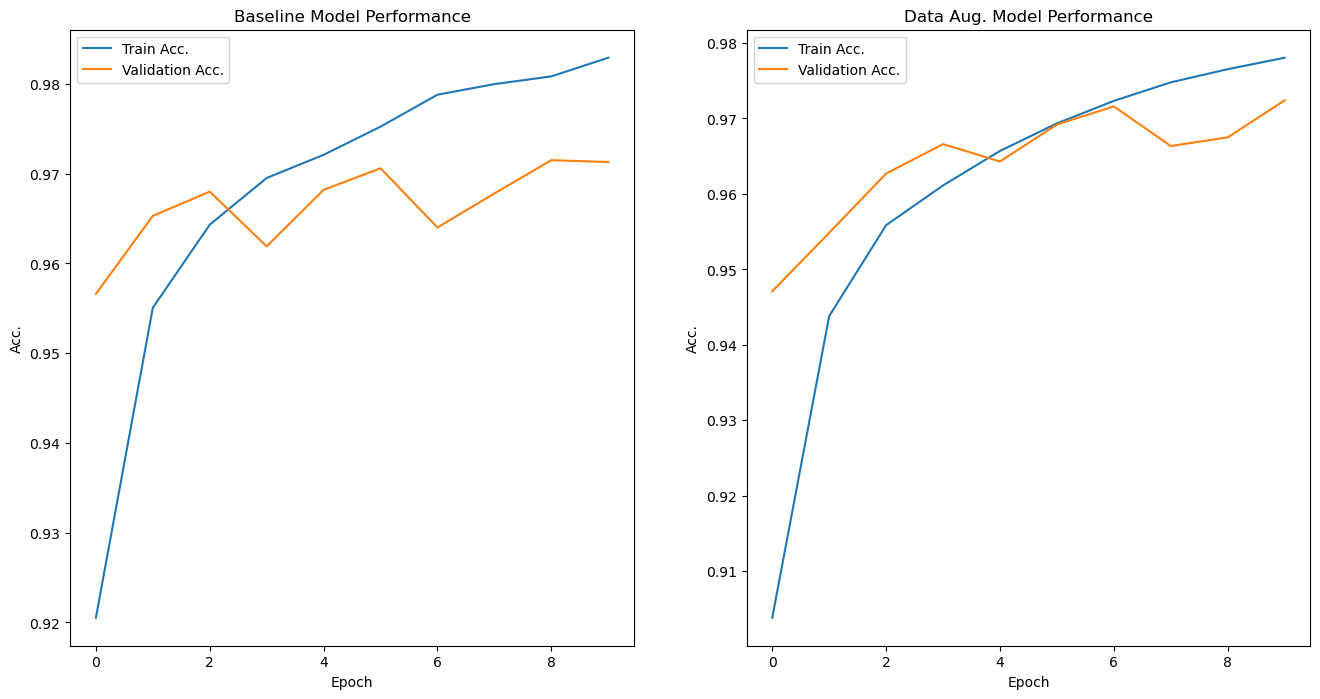

In [95]:
# Let's compare the Accuracy curve during traninng both models
fig = pyplot.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
pyplot.plot(np.arange(0, 10), H.history['accuracy'])
pyplot.plot(H.history['val_accuracy'])
pyplot.title('Baseline Model Performance')
pyplot.ylabel('Acc.')
pyplot.xlabel('Epoch')
pyplot.legend(['Train Acc.', 'Validation Acc.'], loc = 'upper left')
ax = fig.add_subplot(1, 2, 2)
pyplot.plot(np.arange(0, 10), H_aug.history['accuracy'])
pyplot.plot(H_aug.history['val_accuracy'])
pyplot.title('Data Aug. Model Performance')
pyplot.ylabel('Acc.')
pyplot.xlabel('Epoch')
pyplot.legend(['Train Acc.', 'Validation Acc.'], loc = 'upper left')

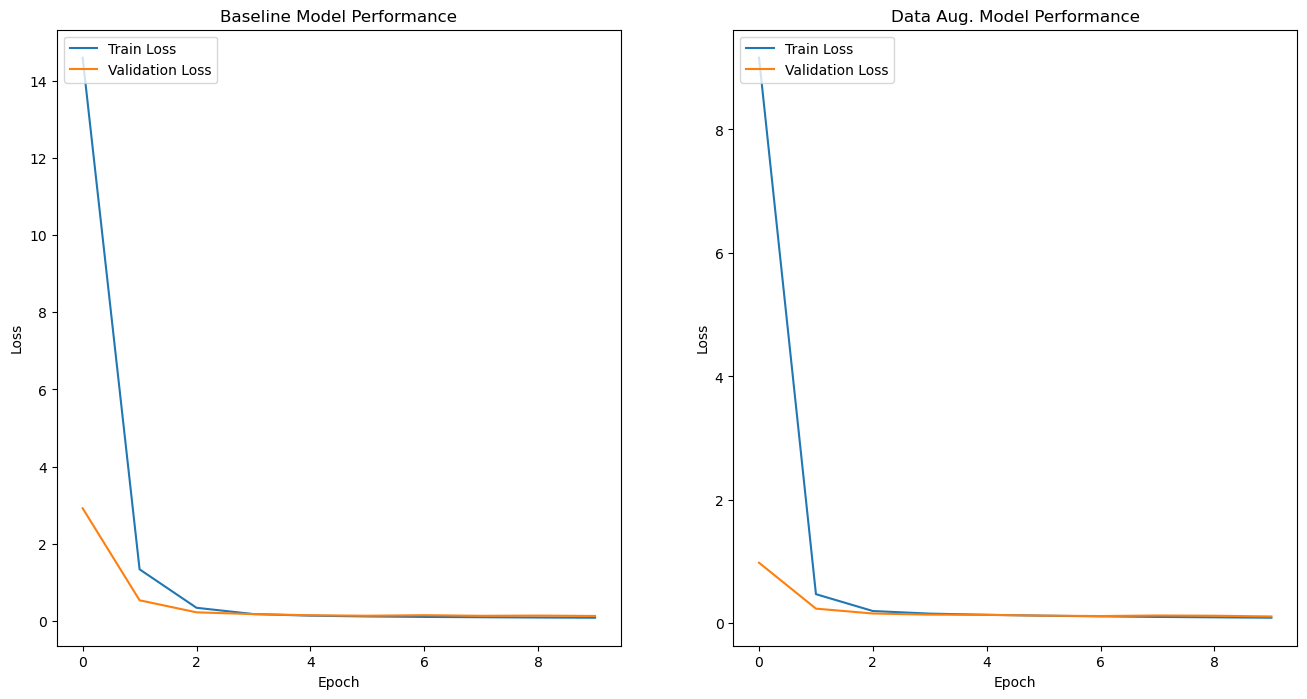

In [98]:
# Let's compare the Loss curve during traninng both models
fig = pyplot.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
pyplot.plot(np.arange(0, 10), H.history['loss'])
pyplot.plot(H.history['val_loss'])
pyplot.title('Baseline Model Performance')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train Loss', 'Validation Loss'], loc = 'upper left')
ax = fig.add_subplot(1, 2, 2)
pyplot.plot(np.arange(0, 10), H_aug.history['loss'])
pyplot.plot(H_aug.history['val_loss'])
pyplot.title('Data Aug. Model Performance')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train Loss', 'Validation Loss'], loc = 'upper left')

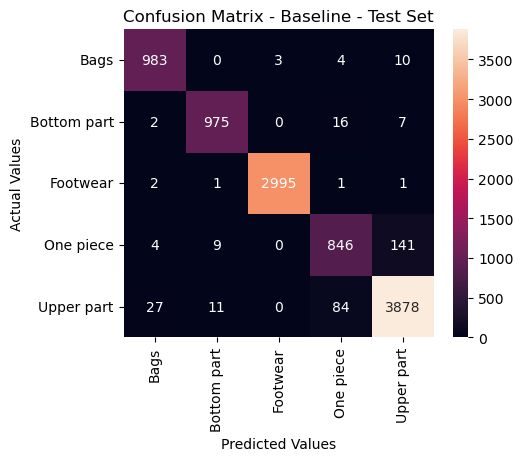

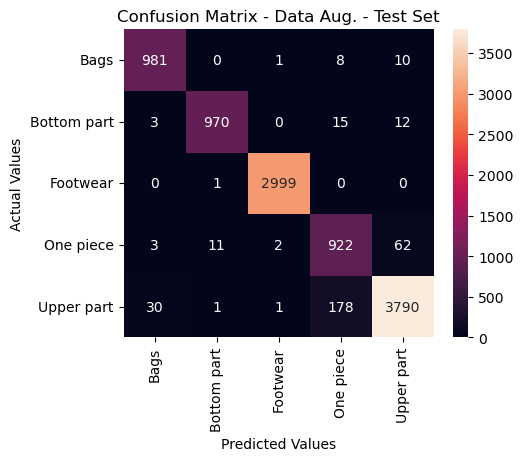

In [99]:
# Now let's compare the confusion matrices for both models over the test set
plot_confusion_matrix(confusion_matrix = cm_test_base, 
                      title = 'Confusion Matrix - Baseline - Test Set')
plot_confusion_matrix(confusion_matrix = cm_test_aug, 
                      title = 'Confusion Matrix - Data Aug. - Test Set')

Let's compare the some metrics for each class for both models. The `precision` is referred to the proportion of correct predictions among all predictions for a particular class (TP/(TP+FP)).

In [100]:
precision_base = precision_score(np.argmax(testY_base, axis=-1), pred_test_base, labels=[0,1,2,3,4], average=None)
print('Precision Baseline')
for i, class_name in enumerate(['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part']):
    print(' ' + class_name + ': {:.2f}'.format(precision_base[i])) 

Precision Baseline
 Bags: 0.97
 Bottom part: 0.98
 Footwear: 1.00
 One piece: 0.89
 Upper part: 0.96


In [101]:
precision_aug = precision_score(np.argmax(testY_aug, axis=-1), pred_test_aug, labels=[0,1,2,3,4], average=None)
print('Precision Aug. Data')
for i, class_name in enumerate(['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part']):
    print(' ' + class_name + ': {:.2f}'.format(precision_aug[i])) 

Precision Aug. Data
 Bags: 0.96
 Bottom part: 0.99
 Footwear: 1.00
 One piece: 0.82
 Upper part: 0.98


The `recall` is referred to the proportion of correct predictions among all predictions for a particular class.

In [102]:
recall_base = recall_score(np.argmax(testY_base, axis=-1), pred_test_base, labels=[0,1,2,3,4], average=None)
print('Recall Baseline')
for i, class_name in enumerate(['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part']):
    print(' ' + class_name + ': {:.2f}'.format(recall_base[i])) 

Recall Baseline
 Bags: 0.98
 Bottom part: 0.97
 Footwear: 1.00
 One piece: 0.85
 Upper part: 0.97


In [104]:
recall_aug = recall_score(np.argmax(testY_aug, axis=-1), pred_test_aug, labels=[0,1,2,3,4], average=None)
print('Recall Aug. Data')
for i, class_name in enumerate(['Bags', 'Bottom part', 'Footwear', 'One piece', 'Upper part']):
    print(' ' + class_name + ': {:.2f}'.format(recall_aug[i]))

Recall Aug. Data
 Bags: 0.98
 Bottom part: 0.97
 Footwear: 1.00
 One piece: 0.92
 Upper part: 0.95


As F1 is some kind of weighted mean between Precision and Recall and it is more difficult to interpretate, we are going to keep only Precision and Recall for this project. The results are pretty similar in both cases. For *Bags*, *Bottom Part* and *Footwear*, the confusion matrix, the precision and the recall are almost the same. We see some differences among the *One piece* and the *Upper part* classes. While in the baseline model the precision for *Upper part* class is lower, for the *One piece* class the recall is better and viceversa in the recall metric.

In conclusion, both of them have good performances. It is true the assumption that it would be more difficult to differentiate between *One piece* and *Upper part* because visually they are more similar between them than with the rest of classes, but almost all the metric values are above 92%, which can be considered acceptable.

Using DenseNet, and taking into consideration that we have finetuned a small part of the Neural Network, we have achieved our goal or not overfitting the model.

### Next Steps

As we have seen, this is a simple and precise exercise in which I have just used one pretrained model in two different experiments, one with the original data and the other one with some data augmentation. As next steps, we have the following options:
* Use more models to campare the results. In that case we could use the validation set to compare them. Here we have used the test set to compare both models because the validation set was different in each example, and it does not make sense to compare the results of the models over different sets of data.
* Use different combinations ofn the data augmentation techniques implemented here.
* Use other data augmentation techniques as synthetic data, kernel filters (i.e. smoothing), random erasing, etc.
* Propose other approach for the model. One could be to train a model for each class facing it to the rest of classes (one-vs-all), developing 5 methods and obtaining the final classification from them. Or maybe making more effort in differentiating between *Upper class* and *One piece* clothes.